In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import random
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_raw

In [2]:
from typing import Callable, Optional
import numpy as np
import os

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
shapeDict = {
    'bloodmnist.npz': [28, 28, 3],
    'breastmnist.npz': [28, 28],
    'dermamnist.npz': [28, 28, 3],
    'octmnist.npz': [28, 28],
    'organamnist.npz': [28, 28],
    'organcmnist.npz': [28, 28],
    'organsmnist.npz': [28, 28],
    'pathmnist.npz': [28, 28, 3],
    'pneumoniamnist.npz': [28, 28],
    'retinamnist.npz': [28, 28, 3],
    'tissuemnist.npz': [28, 28]
}

In [6]:
files = list(shapeDict.keys())
files

['bloodmnist.npz',
 'breastmnist.npz',
 'dermamnist.npz',
 'octmnist.npz',
 'organamnist.npz',
 'organcmnist.npz',
 'organsmnist.npz',
 'pathmnist.npz',
 'pneumoniamnist.npz',
 'retinamnist.npz',
 'tissuemnist.npz']

In [7]:
import pandas as pd

In [8]:
# df = pd.DataFrame(columns=['id','id_image_in_task','task_name','label'])
# df

In [9]:
# global_idx = 0

# for file, name in map(lambda x: (os.path.join('data', x), x.removesuffix('.npz')), os.listdir('data')):
#     data = np.load(file)
#     print(file)
#     for key in data.keys():
#         print(f"\t{key} : {data[key].shape}")
#     result = pd.DataFrame({
#                 'id': global_idx+idx,
#                 'id_image_in_task': idx,
#                 'task_name': name,
#                 'label': 0#i[0]
#             } for idx, i in enumerate(data['test_labels']))
#     global_idx = global_idx + len(result)
#     df = pd.concat([df, result])

In [10]:
# df.to_csv('tmp.csv', index=False)

In [9]:
for file in map(lambda x: os.path.join('data', x), files):
    data = np.load(file)
    print(file)
    for key in data.keys():
        print(f"\t{key} : {data[key].shape}")

data\bloodmnist.npz
	train_images : (11959, 28, 28, 3)
	train_labels : (11959, 1)
	val_images : (1712, 28, 28, 3)
	val_labels : (1712, 1)
	test_images : (3421, 28, 28, 3)
	test_labels : (3421, 1)
data\breastmnist.npz
	train_images : (546, 28, 28)
	val_images : (78, 28, 28)
	test_images : (156, 28, 28)
	train_labels : (546, 1)
	val_labels : (78, 1)
	test_labels : (156, 1)
data\dermamnist.npz
	train_images : (7007, 28, 28, 3)
	val_images : (1003, 28, 28, 3)
	test_images : (2005, 28, 28, 3)
	train_labels : (7007, 1)
	val_labels : (1003, 1)
	test_labels : (2005, 1)
data\octmnist.npz
	train_images : (97477, 28, 28)
	val_images : (10832, 28, 28)
	test_images : (1000, 28, 28)
	train_labels : (97477, 1)
	val_labels : (10832, 1)
	test_labels : (1000, 1)
data\organamnist.npz
	train_images : (34581, 28, 28)
	val_images : (6491, 28, 28)
	test_images : (17778, 28, 28)
	train_labels : (34581, 1)
	val_labels : (6491, 1)
	test_labels : (17778, 1)
data\organcmnist.npz
	train_images : (13000, 28, 28)
	v

Dataset: dermamnist.npz
Unique Labels: [0 1 2 3 4 5 6]
Label Counts: [ 327  514 1099  115 1113 6705  142]


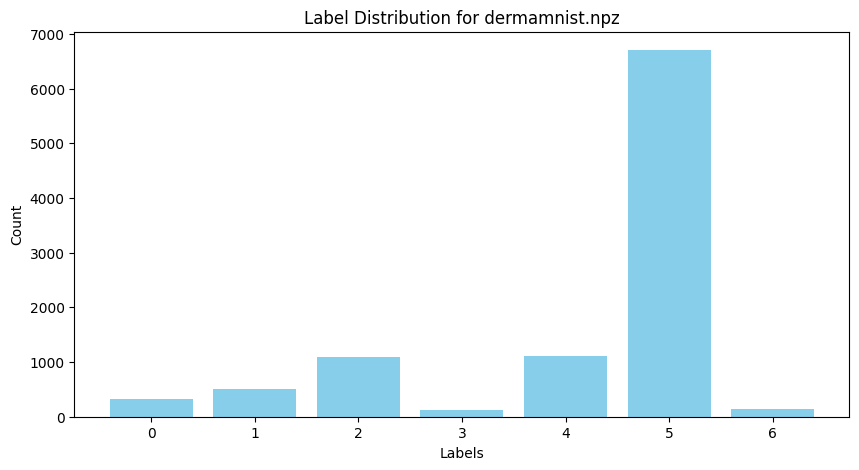

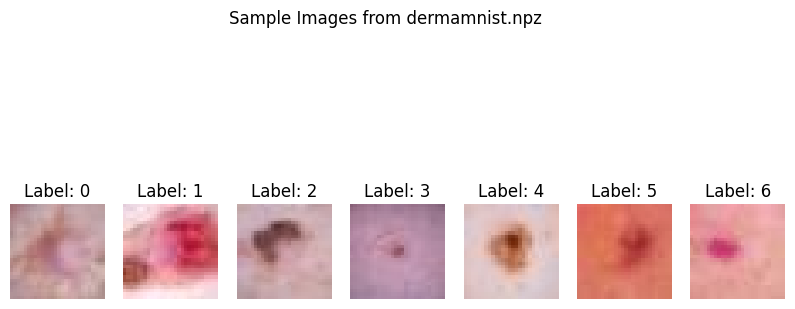

Dataset: organsmnist.npz
Unique Labels: [ 0  1  2  3  4  5  6  7  8  9 10]
Label Counts: [2147 1180 1157 1477 1976 1971 6033 1399 1517 3627 2737]


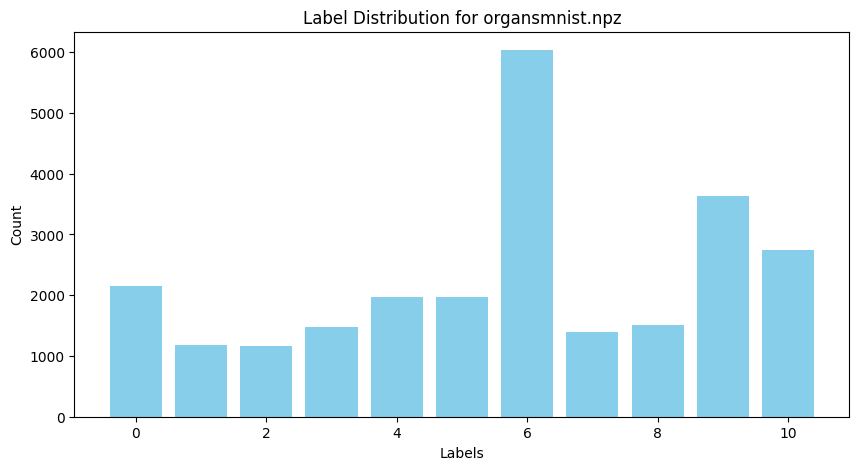

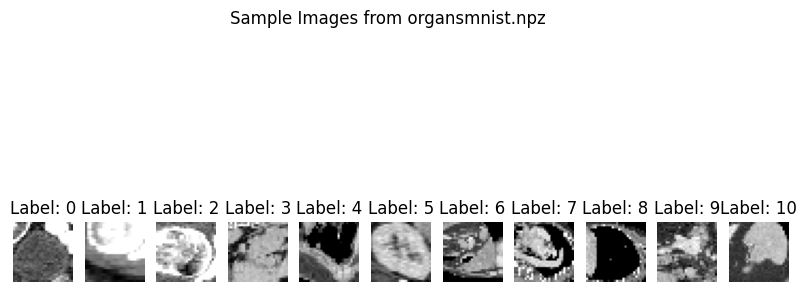

Dataset: pathmnist.npz
Unique Labels: [0 1 2 3 4 5 6 7 8]
Label Counts: [11745 11413 11851 12191  9931 14128  9504 10867 15550]


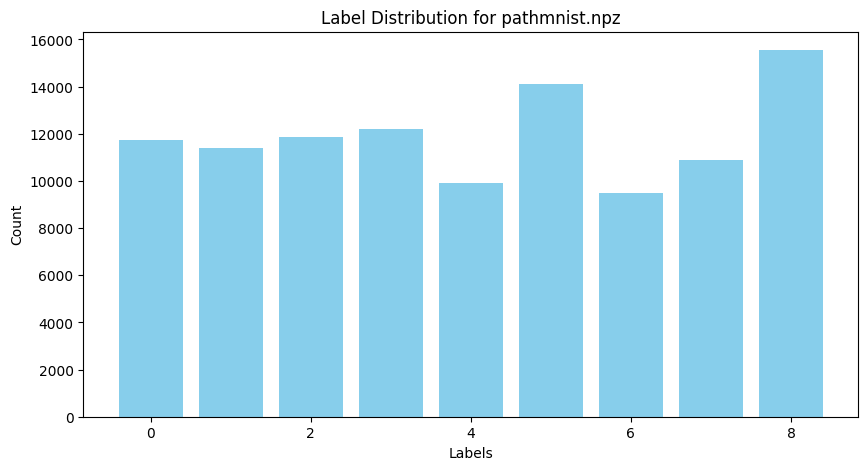

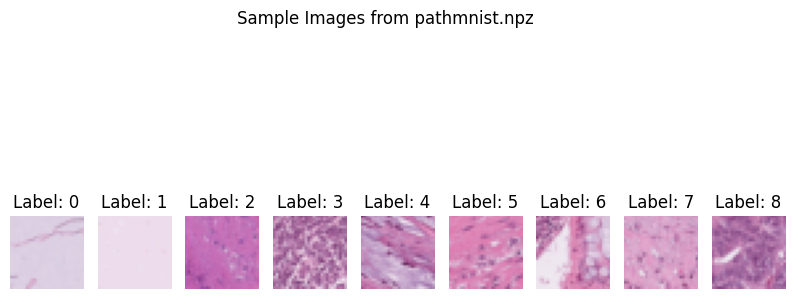

Dataset: retinamnist.npz
Unique Labels: [0 1 2 3 4]
Label Counts: [714 186 326 282  92]


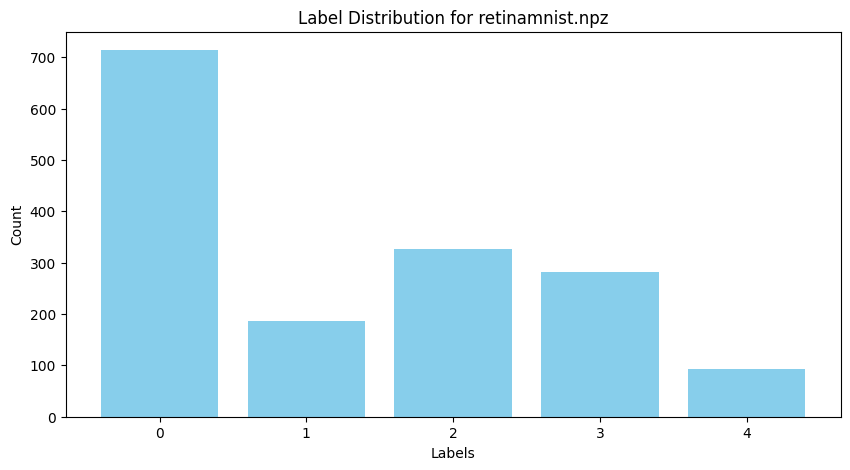

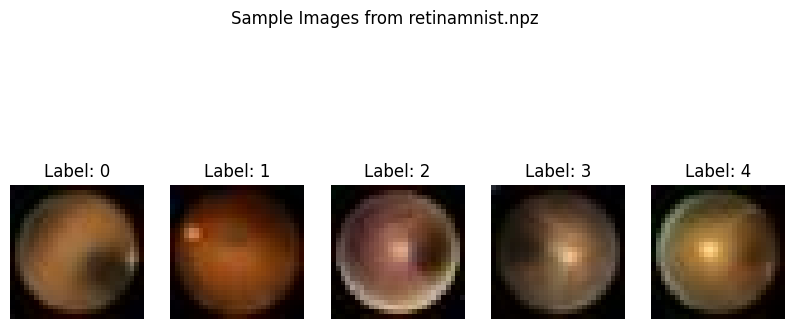

Dataset: tissuemnist.npz
Unique Labels: [0 1 2 3 4 5 6 7]
Label Counts: [75822 11164  8381 22009 16842 11008 56005 35155]


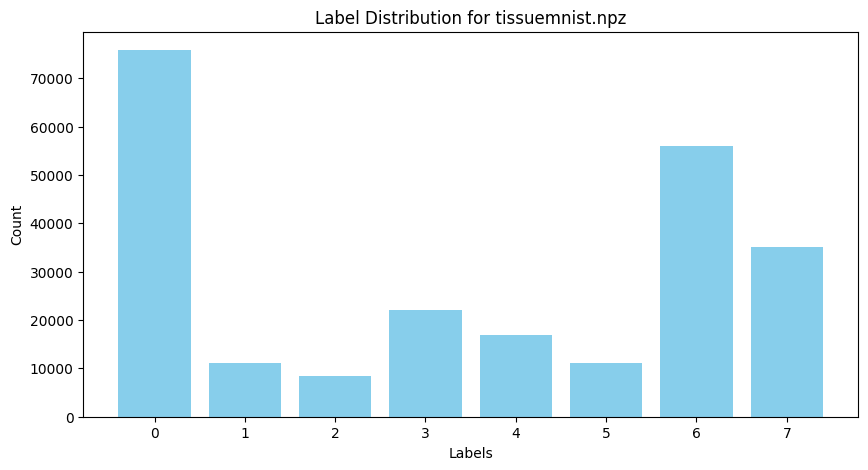

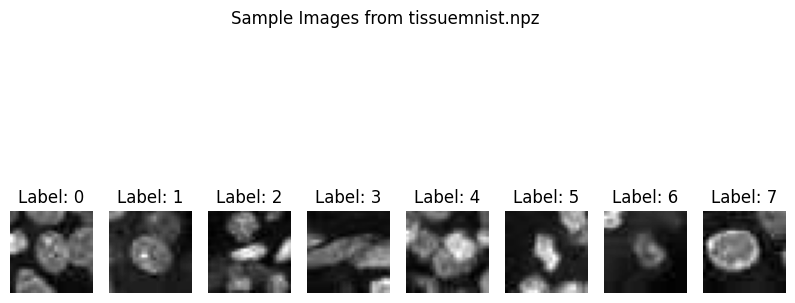

In [12]:
# Function to load and analyze a dataset
def analyze_dataset(dataset_name, dataset_path):
    # Load the dataset
    data = np.load(dataset_path)
    
    # Extract images and labels
    train_images = data['train_images']
    train_labels = data['train_labels']
    val_images = data['val_images']
    val_labels = data['val_labels']
    test_images = data['test_images']
    test_labels = data['test_labels']
    
    # Combine all labels
    all_labels = np.concatenate([train_labels, val_labels, test_labels])
    
    # Get unique labels and their counts
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    
    # Print unique labels and their counts
    print(f"Dataset: {dataset_name}")
    print(f"Unique Labels: {unique_labels}")
    print(f"Label Counts: {counts}")
    
    # Plot label distribution
    plt.figure(figsize=(10, 5))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.title(f"Label Distribution for {dataset_name}")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.show()
    
    # Visualize sample images
    plt.figure(figsize=(10, 5))
    for i, label in enumerate(unique_labels):
        # Find the first image with this label
        idx = np.where(all_labels == label)[0][0]
        image = train_images[idx] if idx < len(train_images) else val_images[idx - len(train_images)]
        
        # Plot the image
        plt.subplot(1, len(unique_labels), i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(f"Sample Images from {dataset_name}")
    plt.show()

# Analyze all datasets
for dataset_name, dataset_path in map(lambda x: (x, os.path.join('data', x)), files):
    analyze_dataset(dataset_name, dataset_path)

```bash
----------------------------------------------------
Loading:  bloodmnist.npz
----------------------------------------------------
Test Accuracy: 94.86%
F1 Score: 0.9417
----------------------------------------------------
Loading:  breastmnist.npz
----------------------------------------------------
Test Accuracy: 87.18%
F1 Score: 0.8346
----------------------------------------------------
Loading:  dermamnist.npz
----------------------------------------------------
Test Accuracy: 76.26%
F1 Score: 0.5903
----------------------------------------------------
Loading:  octmnist.npz
----------------------------------------------------
Test Accuracy: 76.60%
F1 Score: 0.7425
----------------------------------------------------
Loading:  organamnist.npz
----------------------------------------------------
Test Accuracy: 91.07%
F1 Score: 0.9092
----------------------------------------------------
Loading:  organcmnist.npz
----------------------------------------------------
Test Accuracy: 89.34%
F1 Score: 0.8829
----------------------------------------------------
Loading:  organsmnist.npz
----------------------------------------------------
Test Accuracy: 76.92%
F1 Score: 0.7329
----------------------------------------------------
Loading:  pathmnist.npz
----------------------------------------------------
Test Accuracy: 85.26%
F1 Score: 0.8085
----------------------------------------------------
Loading:  pneumoniamnist.npz
----------------------------------------------------
Test Accuracy: 86.54%
F1 Score: 0.8438
----------------------------------------------------
Loading:  retinamnist.npz
----------------------------------------------------
Test Accuracy: 54.25%
F1 Score: 0.3520
----------------------------------------------------
Loading:  tissuemnist.npz
----------------------------------------------------
Test Accuracy: 67.97%
F1 Score: 0.5857
```

In [10]:
# filename = 'bloodmnist.npz' # 94.17 => 95 => 
# filename = 'breastmnist.npz' # 83.46 => 84.87
# filename = 'dermamnist.npz' # 56.97 => 59
# filename = 'octmnist.npz' # 74 => 76
# filename = 'organamnist.npz' # 90 => 92.6915
# filename = 'organcmnist.npz' # => 88.29 => 90
# filename = 'organsmnist.npz' # 68.87 => 73.29
# filename = 'pathmnist.npz' # 77.74 => 80
# filename = 'pneumoniamnist.npz' # 84 => 85
filename = 'retinamnist.npz' # 32.21 => 35.20
# filename = 'tissuemnist.npz' # 54.19 => 58.5719


data = np.load(os.path.join('data', filename)) 

# List the keys in the file
print("Available labels:", set(i[0] for i in data['train_labels']))

# Access specific arrays
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']


# Example: Print shapes or details
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

black_and_white = len(shapeDict[filename]) == 2
num_classes = len(np.unique(train_labels))
print("LABELS: ", np.unique(train_labels))
print("black_and_white: ", black_and_white)
print("num_classes: ", num_classes)

# Close the .npz file
data.close()

Available labels: {np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4)}
Train images shape: (1080, 28, 28, 3)
Train labels shape: (1080, 1)
Validation images shape: (120, 28, 28, 3)
Validation labels shape: (120, 1)
Test images shape: (400, 28, 28, 3)
Test labels shape: (400, 1)
LABELS:  [0 1 2 3 4]
black_and_white:  False
num_classes:  5


In [11]:
def mean_and_std(data: np.ndarray, black_and_white: bool):
    """
    Calculate the mean and standard deviation for the given dataset.

    Args:
    - data (np.ndarray): The dataset as a NumPy array, shape (N, H, W, C) for color images.
    - black_and_white (bool): Whether the images are black and white (grayscale).

    Returns:
    - tuple: (mean, std) to be used in v2.Normalize().
    """
    if black_and_white:
        # For grayscale images (1 channel)
        flattened_images = data.reshape(data.shape[0], -1)  # Flatten to (N, H*W)
        mean = np.mean(flattened_images) / 255.0
        std = np.std(flattened_images) / 255.0
        return (mean,), (std,)  # Return as single channel tuple
    else:
        # For color images (3 channels)
        # Reorder the dimensions of data to (N, H, W, C) -> (N, C, H, W)
        data = data.transpose(0, 3, 1, 2)  # Shape: (N, C, H, W)
        
        # Flatten the images to compute mean and std for each channel separately
        flattened_images = data.reshape(data.shape[0], data.shape[1], -1)  # Shape: (N, C, H*W)
        mean = np.mean(flattened_images, axis=(0, 2)) / 255.0  # Mean across H and W for each channel
        std = np.std(flattened_images, axis=(0, 2)) / 255.0  # Std across H and W for each channel
        return tuple(mean), tuple(std)  # Return as tuples for each channel
    
class MedMnistToTensor(nn.Module):
    def __init__(self, black_and_white: bool):
        super(MedMnistToTensor, self).__init__()
        if black_and_white:
            self.transform: Callable[[Tensor], Tensor] = lambda x: x.mul_(1.0 / 255.0).unsqueeze_(-1)
        else:
            self.transform: Callable[[Tensor], Tensor] = lambda x: x.mul_(1.0 / 255.0)
        
    def forward(self, x: np.ndarray) -> Tensor:
        # x has a shape of [N, 28, 28] or [N, 28, 28, 3]
        x: Tensor = torch.from_numpy(x).to(dtype=torch.float32)
        x: Tensor = self.transform(x)
        return x.permute((0, 3, 1, 2)).contiguous()
    
cached_transforms = v2.Compose([
        MedMnistToTensor(black_and_white=black_and_white),
])

In [12]:
mean_image, std_image = mean_and_std(train_images, black_and_white=black_and_white)
print("MEAN: ", mean_image)
print("STD: ", std_image)

# runtime_transforms = v2.Compose([
#     # v2.RandomCrop(32, padding=4, fill=0.5),
#     v2.RandomHorizontalFlip(),
#     # v2.RandomAffine(degrees=(-10, 10), shear=(-5, 5), fill=0.5),
#     # v2.RandomErasing(scale=(0.05, 0.15), value=0.5, inplace=False),
#     v2.Normalize(mean=mean_image, std=std_image, inplace=False),
#     lambda x: x.to(device)
# ])
# test_transforms = v2.Compose([
#     MedMnistToTensor(black_and_white=black_and_white),
#     v2.Normalize(mean=mean_image, std=std_image, inplace=True)
# ])

# Usage example
runtime_transforms = v2.Compose([
    # Spatial augmentations
    v2.RandomRotation(10),
    v2.RandomResizedCrop(size=28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    v2.RandomHorizontalFlip(),

    # Color/intensity augmentations
    v2.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
    v2.ColorJitter(brightness=0.1, contrast=0.1),

    # Noise and other augmentations
    v2.RandomApply([
        v2.GaussianBlur(kernel_size=3)
    ], p=0.1),

    # Normalization
    v2.Normalize(mean=mean_image, std=std_image, inplace=False),
])

test_transforms = v2.Compose([
    MedMnistToTensor(black_and_white=black_and_white),
    # Normalization only
    v2.Normalize(mean=mean_image, std=std_image, inplace=False),
])

MEAN:  (np.float64(0.39838941595156585), np.float64(0.24472671012849584), np.float64(0.15575321332236597))
STD:  (np.float64(0.29828646114774376), np.float64(0.2004824202154765), np.float64(0.1506595332367727))


In [13]:

class MedMnistDataset(Dataset):
    def __init__(self, 
                 name: str, 
                 data: np.ndarray, 
                 labels: np.ndarray, 
                 cached_transforms: Callable, 
                 runtime_transforms: Optional[Callable]):
        self.name = name
        self.data = cached_transforms(data).to(device)
        self.labels = torch.from_numpy(labels.flatten()).to(device)
        # self.indices = torch.arange(len(self.labels)).to(device)
        self.num_classes = np.max(labels) + 1
        self.runtime_transforms = runtime_transforms if runtime_transforms is not None else lambda x: x
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, i: int):
        return self.labels[i], self.runtime_transforms(self.data[i])
        # return {
        #     'name': self.name,  # It might be a good idea to use this during training!
        #     'id_image_in_task': self.indices[i],  # You should not use this during training
        #     'data': self.runtime_transforms(self.data[i]),   # Must use during training :)
        #     'labels': self.labels[i]  # The GT
        # }

train_dataset = MedMnistDataset(filename,
                                train_images, 
                                train_labels, 
                                cached_transforms,
                                runtime_transforms)
val_dataset = MedMnistDataset(filename,
                              val_images, 
                              val_labels, 
                              test_transforms,
                              None)
test_dataset = MedMnistDataset(filename, 
                               test_images, 
                               test_labels, 
                               test_transforms, 
                               None)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500)
test_loader = DataLoader(test_dataset, batch_size=500)

In [14]:
train_dataset[0]

(tensor(0, device='cuda:0', dtype=torch.uint8),
 tensor([[[-1.3356, -1.3356, -1.3255,  ..., -1.2831, -1.2824, -1.2697],
          [-1.3356, -1.3356, -1.3051,  ..., -1.2597, -1.2476, -1.2137],
          [-1.3009, -1.2917, -1.3226,  ..., -1.2018, -1.2409, -1.2030],
          ...,
          [-1.3356, -1.3356, -1.2718,  ..., -1.3077, -1.3238, -1.3356],
          [-1.3356, -1.3356, -1.3264,  ..., -1.2988, -1.3238, -1.3356],
          [-1.3356, -1.3356, -1.3356,  ..., -1.2988, -1.3238, -1.3356]],
 
         [[-1.2207, -1.2207, -1.1876,  ..., -1.2184, -1.1812, -1.1624],
          [-1.2207, -1.2207, -1.1572,  ..., -1.2207, -1.2207, -1.1457],
          [-1.1546, -1.1408, -1.1688,  ..., -1.2207, -1.2207, -1.2007],
          ...,
          [-1.2207, -1.2207, -1.1487,  ..., -1.2207, -1.2207, -1.2207],
          [-1.2207, -1.2207, -1.2207,  ..., -1.2207, -1.2207, -1.2207],
          [-1.2207, -1.2207, -1.2207,  ..., -1.2056, -1.2207, -1.2207]],
 
         [[-0.9298, -0.9548, -0.9322,  ..., -1.0338,

![](https://i.sstatic.net/vD1u3.png)

In [15]:
class ModelBlock(nn.Module):
    def __init__(self):
        super(ModelBlock, self).__init__()
        self.convBlock = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.GELU()
        ) # n*32*14*14 => n*32*14*14
        
    def forward(self, x: Tensor) -> Tensor:
        return self.convBlock(x)
        
class Modelpp(nn.Module):
    def __init__(self, black_and_white: bool, num_classes: int, num_blocks: int = 12, skip_after: int = 3, p: int = 0.5, skip_conn: bool = True):
        super(Modelpp, self).__init__()
        assert num_blocks % skip_after == 0, "num_blocks must be divisible by skip_after"
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1 if black_and_white else 3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)   
        ) # n*c*28*28 => n*32*14*14
        
        self.skip_conn = skip_conn
        
        self.num_block_per_not_skip = num_blocks // skip_after
        self.blocks_not_skip = nn.ModuleList([ModelBlock() for _ in range(skip_after)]) # n*32*14*14 => n*32*14*14
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)   
        ) # n*32*14*14 => n*64*7*7
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # nn.MaxPool2d(2)   
            nn.AdaptiveAvgPool2d((4, 4))  # Ensures fixed-size feature map before FC layer
        ) # n*64*7*7 => n*128*4*4
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Flatten the output from convolution layers
        self.fc2 = nn.Linear(512, num_classes)    # Output layer with 'num_classes' nodes

        # Dropout for regularization
        self.dropout = nn.Dropout(p)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        
        for _ in range(self.num_block_per_not_skip):
            # x = x + self.blocks_not_skip(x)
            skip_x = x
            for block in self.blocks_not_skip:
                x = block(x)
                # x = self.dropout(x)   # Apply dropout
            if self.skip_conn: x = skip_x + x
            
        x = self.conv2(x)
        
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, -1)
        
        # Apply fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))    # Fully connected layer 1
        x = self.dropout(x)        # Apply dropout
        x = self.fc2(x)            # Fully connected layer 2 (output layer)
        return x

In [17]:
ModelBlock()(
    torch.randn((8, 32, 14, 14))
).shape

torch.Size([8, 32, 14, 14])

In [18]:
# Create model instance
model = Modelpp(black_and_white=black_and_white, num_classes=num_classes, num_blocks=12, skip_after=3, skip_conn=True).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [21]:
# Example training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for labels, inputs in tqdm_raw(train_loader):
        labels, inputs = labels, inputs
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm, etc.)
    correct = 0
    total = 0
    all_true_labels = []
    all_pred_labels = []
    with torch.no_grad():  # No gradient computation during validation
        for labels, inputs in val_loader:  # Assuming you have a validation data loader (val_loader)
            labels, inputs = labels, inputs
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                        
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(predicted.cpu().numpy())

            loss = criterion(outputs, labels)
            # scheduler.step(loss)
            # scheduler.step()

    val_accuracy = 100 * correct / total
    f1 = f1_score(all_true_labels, all_pred_labels, average='macro') * 100
    print(f"Validation Accuracy after Epoch {epoch+1}: {val_accuracy:.2f}% F1 Score: {f1:.4f}%")

100%|██████████| 5/5 [00:05<00:00,  1.01s/it]


Epoch 1/20, Loss: 1.5689738750457765
Validation Accuracy after Epoch 1: 46.67% F1 Score: 20.5019%


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 2/20, Loss: 1.2674841642379762
Validation Accuracy after Epoch 2: 47.50% F1 Score: 23.8041%


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch 3/20, Loss: 1.1938973903656005
Validation Accuracy after Epoch 3: 51.67% F1 Score: 34.7904%


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 4/20, Loss: 1.1695205450057984
Validation Accuracy after Epoch 4: 47.50% F1 Score: 24.8504%


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 5/20, Loss: 1.217237639427185
Validation Accuracy after Epoch 5: 58.33% F1 Score: 39.6768%


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 6/20, Loss: 1.1908379316329956
Validation Accuracy after Epoch 6: 58.33% F1 Score: 40.7505%


100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch 7/20, Loss: 1.1517312049865722
Validation Accuracy after Epoch 7: 61.67% F1 Score: 44.2206%


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 8/20, Loss: 1.1575659275054933
Validation Accuracy after Epoch 8: 59.17% F1 Score: 42.3962%


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 9/20, Loss: 1.1138174653053283
Validation Accuracy after Epoch 9: 60.83% F1 Score: 44.4862%


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 10/20, Loss: 1.1628468751907348
Validation Accuracy after Epoch 10: 55.83% F1 Score: 40.3530%


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch 11/20, Loss: 1.126074242591858
Validation Accuracy after Epoch 11: 58.33% F1 Score: 42.7288%


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch 12/20, Loss: 1.1303223609924316
Validation Accuracy after Epoch 12: 52.50% F1 Score: 36.7195%


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 13/20, Loss: 1.1664610624313354
Validation Accuracy after Epoch 13: 60.00% F1 Score: 43.6848%


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch 14/20, Loss: 1.1774025678634643
Validation Accuracy after Epoch 14: 60.00% F1 Score: 44.5306%


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch 15/20, Loss: 1.1384398221969605
Validation Accuracy after Epoch 15: 50.83% F1 Score: 35.8564%


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch 16/20, Loss: 1.1261983156204223
Validation Accuracy after Epoch 16: 55.83% F1 Score: 40.4525%


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch 17/20, Loss: 1.1258435010910035
Validation Accuracy after Epoch 17: 57.50% F1 Score: 41.1158%


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch 18/20, Loss: 1.1302743196487426
Validation Accuracy after Epoch 18: 53.33% F1 Score: 38.9723%


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch 19/20, Loss: 1.1370589017868042
Validation Accuracy after Epoch 19: 57.50% F1 Score: 40.8436%


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch 20/20, Loss: 1.1260302305221557
Validation Accuracy after Epoch 20: 58.33% F1 Score: 39.6224%


In [22]:
correct = 0
total = 0
model.eval()

all_true_labels = []
all_pred_labels = []

with torch.no_grad():  # No gradient computation during testing
    for labels, inputs in test_loader:  # Assuming you have a test data loader (test_loader)
            labels, inputs = labels.to(device), inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(predicted.cpu().numpy())

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    # Compute F1 score (macro) for the whole dataset
    f1 = f1_score(all_true_labels, all_pred_labels, average='macro') * 100
    print(f"F1 Score: {f1:.4f}")

Test Accuracy: 55.00%
F1 Score: 36.0958


In [23]:
correct = 0
total = 0
model.eval()

all_true_labels = []
all_pred_labels = []

with torch.no_grad():  # No gradient computation during testing
    for labels, inputs in tqdm_raw(train_loader):  # Assuming you have a test data loader (test_loader)
            labels, inputs = labels.to(device), inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(predicted.cpu().numpy())

    test_accuracy = 100 * correct / total
    print(f"Train Accuracy: {test_accuracy:.2f}%")
    # Compute F1 score (macro) for the whole dataset
    f1 = f1_score(all_true_labels, all_pred_labels, average='macro') * 100
    print(f"F1 Score: {f1:.4f}")

100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

Train Accuracy: 55.37%
F1 Score: 36.7564


In [322]:
torch.save(model.state_dict(), os.path.join("modelpp", f"{filename}.pth"))

![f1-score-image](https://www.researchgate.net/publication/367393140/figure/fig4/AS:11431281114710300@1674648981676/Confusion-matrix-Precision-Recall-Accuracy-and-F1-score.jpg)

In [24]:
class Model(nn.Module):
    def __init__(self, black_and_white: bool, num_classes: int):
        super(Model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1 if black_and_white else 3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   
        ) # n*c*28*28 => n*32*14*14
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   
        ) # n*32*14*14 => n*64*7*7
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   
        ) # n*64*7*7 => n*128*4*4
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Flatten the output from convolution layers
        self.fc2 = nn.Linear(512, num_classes)    # Output layer with 'num_classes' nodes

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, -1)
        
        # Apply fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))    # Fully connected layer 1
        x = self.dropout(x)        # Apply dropout
        x = self.fc2(x)            # Fully connected layer 2 (output layer)
        return x

In [ ]:



accuracy = {
    
}
df = pd.DataFrame(columns=['id','id_image_in_task','task_name','label'])
global_idx = 0
f1_scores = []

for filename in os.listdir('data'): #
    usePP = True # filename in ['dermamnist.npz', 'organsmnist.npz', 'pathmnist.npz', 'retinamnist.npz', 'tissuemnist.npz']    
        
    name = filename.removesuffix('.npz')
    print("----------------------------------------------------")
    print("Loading: ", filename)
    print("----------------------------------------------------")
    
    data = np.load(os.path.join('data', filename)) 
    # List the keys in the file
    print("Available labels:", set(i[0] for i in data['train_labels']))

    # Access specific arrays
    train_images = data['train_images']
    train_labels = data['train_labels']
    val_images = data['val_images']
    val_labels = data['val_labels']
    test_images = data['test_images']
    test_labels = data['test_labels']

    black_and_white = len(shapeDict[filename]) == 2
    num_classes = len(np.unique(train_labels))
    print("LABELS: ", np.unique(train_labels))
    print("black_and_white: ", black_and_white)
    print("num_classes: ", num_classes)

    # Close the .npz file
    data.close()
    
    mean_image, std_image = mean_and_std(train_images, black_and_white=black_and_white)
    print("MEAN: ", mean_image)
    print("STD: ", std_image)
    
    test_transforms = v2.Compose([
        MedMnistToTensor(black_and_white=black_and_white),
        v2.Normalize(mean=mean_image, std=std_image, inplace=True)
    ])
    test_dataset = MedMnistDataset(filename, 
                               test_images, 
                               test_labels, 
                               test_transforms, 
                               None)
    test_loader = DataLoader(test_dataset, batch_size=500)
    
    if usePP:
        model = Modelpp(black_and_white=black_and_white, num_classes=num_classes, num_blocks=12, skip_after=3, skip_conn=True).to(device)
    else:
        model = Model(black_and_white=black_and_white, num_classes=num_classes).to(device)
    
    model.load_state_dict(torch.load(os.path.join("modelpp" if usePP else "model", f"{filename}.pth"), weights_only=True))
    
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():  # No gradient computation during testing
        pred_labels = []
        all_true_labels = []
        all_pred_labels = []
        for labels, inputs in test_loader:  # Assuming you have a test data loader (test_loader)
                labels, inputs = labels.to(device), inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pred_labels += [i.cpu().item() for i in predicted]
                all_true_labels.extend(labels.cpu().numpy())
                all_pred_labels.extend(predicted.cpu().numpy())

        
        result = pd.DataFrame({
            'id': global_idx+idx,
            'id_image_in_task': idx,
            'task_name': name,
            'label': pred_label
        } for idx, pred_label in enumerate(pred_labels))
    
        test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        
        # Compute F1 score (macro) for the whole dataset
        f1 = f1_score(all_true_labels, all_pred_labels, average='macro')
        f1_scores.append(f1)
        print(f"F1 Score: {f1:.4f}")
        
    accuracy.update({
        filename: [test_accuracy, total, correct]
    })
    global_idx = global_idx + len(result)
    df = pd.concat([df, result])

In [324]:
print(len(f1_scores) / sum(1/f1 for f1 in f1_scores))

0.6985832004072469


In [325]:
accuracy = list(accuracy.items())

In [326]:
t = 0
c = 0
for name, (acc, total, correct) in accuracy:
    t+=total
    c+=correct
c/t*100

77.93812731455215

In [327]:
df.to_csv('tmp.csv', index=False)